In [1]:
import pandas as pd
#import geopandas as gpd
import json
from ast import literal_eval
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import json
#pip install geopandas
#pip install spacy
#python -m spacy download en_core_web_sm

In [2]:
# read in the dataset 
df = pd.read_json('animal_news_database.json', lines = True)
df

_id                   common_name  \
0     {'$oid': '5eb530eeccc46a6a739577a2'}   Campbell's alligator lizard   
1     {'$oid': '5eb53116ccc46a6a739577a6'}   Southern plains gray langur   
2     {'$oid': '5eb53156ccc46a6a739577ab'}             Natal giant cycad   
3     {'$oid': '5eb53162ccc46a6a739577ad'}         Bengal hanuman langur   
4     {'$oid': '5eb53171ccc46a6a739577af'}            Mongolian Wild Ass   
...                                    ...                           ...   
2272  {'$oid': '5ed349928089be8ca72beb86'}                    Chimpanzee   
2273  {'$oid': '5ed34a668089be8ca72beb87'}             Common chimpanzee   
2274  {'$oid': '5ed352f08089be8ca72beb8a'}              @TRAFFIC_WLTrade   
2275  {'$oid': '5ed355ec8089be8ca72beb8b'}                  @IlWildTrade   
2276  {'$oid': '5ed35b528089be8ca72beb8c'}                  @WLTradeNews   

               scientific_name  \
0            Abronia campbelli   
1     Semnopithecus dussumieri   
2     Encephalartos natalensis   
3       Semnopithecus entellus   
4      Equus hemionus hemionus   
...                        ...   
2272           Pan troglodytes   
2273           Pan troglodytes   
2274          @TRAFFIC_WLTrade   
2275              @IlWildTrade   
2276              @WLTradeNews   

                                           distribution  \
0                                             Guatemala   
1                                                 India   
2                                          South Africa   
3                    Bangladesh, India, Nepal, Pakistan   
4       China, Kazakhstan, Mongolia, Russian Federation   
...                                                 ...   
2272  Angola, Benin, Burkina Faso, Burundi, Cameroon...   
2273  Angola, Benin, Burkina Faso, Burundi, Cameroon...   
2274                                                 NA   
2275                                                 NA   
2276                                                 NA   

                iucn_status  \
0     Critically Endangered   
1             Least Concern   
2           Near Threatened   
3             Least Concern   
4                        NA   
...                     ...   
2272                     EN   
2273                     EN   
2274                     NA   
2275                     NA   
2276                     NA   

                                               articles  date_saved  
0     {'0': {'text': 'A 3-foot-long (1 meter) green ...  2020-06-18  
1     {'3': {'text': 'On Thursday, a Nilgai was foun...  2020-06-18  
2     {'0': {'text': 'A GUIDED walk entitled Interes...  2020-06-18  
3     {'1': {'text': 'Advertisement

From the tropic...  2020-06-18  
4     {'0': {'text': 'Exploding demand for cashmere ...  2020-06-18  
...                                                 ...         ...  
2272  {'0': {'text': 'The Chimpanzee Sanctuary & Wil...  2020-06-18  
2273                                                 {}  2020-06-18  
2274  {'0': {'text': 'Pangolins are trafficked for t...  2020-06-18  
2275  {'0': {'text': 'india

Updated: May 03, 2016 1...  2020-06-18  
2276  {'0': {'text': 'This evening, Prince William a...  2020-06-18  

[2277 rows x 7 columns]

In [30]:
# Read in the datasets defining our subset data

#undoc = pd.read_csv("undoc_species.csv", sep = ";")
charismatic = pd.read_csv("charismatic_16.csv", sep = ";")
#edge = pd.read_csv("non_charismatic_20.csv", sep = ";")

In [31]:
charismatic = charismatic.rename(columns = {'Scientifc Name' : 'scientific_name'})
#charismatic = charismatic[['scientific_name', 'Ecosystem', 'Class']]
#edge = edge.rename(columns = {'Scientifc Name' : 'scientific_name'})
#edge = edge[['scientific_name', 'Ecosystem', 'Class', 'Conservation Attention']]

In [87]:
bear = charismatic.loc[charismatic['General ID name'].isin(['Bear'])]

In [88]:
bear

Common name General ID name  Count   Class    Ecosystem  \
0              Sun Bear            Bear      1  Mammal  Terrestrial   
1            Sloth Bear            Bear      1  Mammal  Terrestrial   
2           Andean Bear            Bear      1  Mammal  Terrestrial   
3            Brown Bear            Bear      1  Mammal  Terrestrial   
4  Himalayan Brown Bear            Bear      1  Mammal  Terrestrial   
5      Asian Black Bear            Bear      1  Mammal  Terrestrial   

            scientific_name  Appendix  \
0       Helarctos malayanus         1   
1          Melursus ursinus         1   
2        Tremarctos ornatus         1   
3              Ursus arctos         1   
4  Ursus arctos isabellinus         1   
5          Ursus thibetanus         1   

                         Appendix exceptions, if any  Unnamed: 8  
0                                                NaN         NaN  
1                                                NaN         NaN  
2                                                NaN         NaN  
3  Only the populations of: Bhutan, China, Mexico...         NaN  
4  Only the populations of: Bhutan, China, Mexico...         NaN  
5                                                NaN         NaN

In [3]:
# Drop Twitter handles as they are not species names
df = df[df.scientific_name.str.contains('@') == False]
df.reset_index(drop = True, inplace = True)
# How many species listed total in this dataset
#df['scientific_name'].nunique()

# Add new column for storing the values article amount found under each species type 
for i, row in df.iterrows():
    df.at[i, 'article_amt'] = len(row.articles.values())
    
#df
## Good syntax to remember to find specific instances of a value in a specific column
#df.loc[df['scientific_name'].isin(['Perameles bougainville'])]

/tmp/ipykernel_141/2259456459.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.at[i, 'article_amt'] = len(row.articles.values())


In [4]:
# Read in the CITES data to join with the top 10 (or 20) most reported on species 
cites1 = pd.read_csv("cites1.csv", delimiter = ';')

# Keep only most relevant columns
cites1 = cites1[['Kingdom', 'Class', 'Order', 'Family', 'Genus', 'Species', 'Scientific Name', 'Listing', 'NativeDistributionFullNames', 'Extinct_Distribution']]

cites1 = cites1.rename(columns = {'Scientific Name' : 'scientific_name'})

# Do the same for the entire dataframe
df = df.merge(cites1, on = 'scientific_name', how = 'inner')


#df.head()

In [5]:
df = df.drop(['_id'], axis=1)

In [83]:
s = rizz['articles'].map(dict.values).explode()
rizz.drop(columns=['articles']).join(pd.DataFrame([*s], s.index))

AttributeError: 'float' object has no attribute 'keys'

In [40]:
rizz.drop(columns=['articles']).join(pd.DataFrame([*s], s.index))
rizz.drop(columns=['articles']).join(pd.json_normalize(s), s.index)

AttributeError: 'float' object has no attribute 'keys'

In [32]:
# Do the same for the entire dataframe
rizz = df.merge(charismatic, on = 'scientific_name', how = 'inner')
#dg = df.merge(edge, on = 'scientific_name', how = 'inner')

In [89]:
# Do the same for the entire dataframe
bear = df.merge(bear, on = 'scientific_name', how = 'inner')
#dg = df.merge(edge, on = 'scientific_name', how = 'inner')

In [94]:
bear = bear.loc[bear['scientific_name'].isin(['Melursus ursinus'])]
bear

common_name   scientific_name                                 distribution  \
0  Sloth Bear  Melursus ursinus  Bangladesh, Bhutan, India, Nepal, Sri Lanka   
1  Sloth Bear  Melursus ursinus  Bangladesh, Bhutan, India, Nepal, Sri Lanka   

  iucn_status                                           articles  date_saved  \
0          VU  {'0': {'text': 'The lockdown on all human acti...  2020-06-18   
1          VU  {'4': {'text': 'The leopard was spotted beside...  2020-06-18   

   article_amt   Kingdom   Class_x      Order  ...  \
0         26.0  Animalia  Mammalia  Carnivora  ...   
1          9.0  Animalia  Mammalia  Carnivora  ...   

               NativeDistributionFullNames Extinct_Distribution Common name  \
0  Bangladesh,Bhutan,India,Nepal,Sri Lanka                  NaN  Sloth Bear   
1  Bangladesh,Bhutan,India,Nepal,Sri Lanka                  NaN  Sloth Bear   

  General ID name Count Class_y    Ecosystem Appendix  \
0            Bear     1  Mammal  Terrestrial        1   
1            Bear     1  Mammal  Terrestrial        1   

   Appendix exceptions, if any Unnamed: 8  
0                          NaN        NaN  
1                          NaN        NaN  

[2 rows x 24 columns]

In [95]:
s = bear['articles'].map(dict.values).explode()
bear.drop(columns=['articles']).join(pd.DataFrame([*s], s.index))

common_name   scientific_name                                 distribution  \
0  Sloth Bear  Melursus ursinus  Bangladesh, Bhutan, India, Nepal, Sri Lanka   
0  Sloth Bear  Melursus ursinus  Bangladesh, Bhutan, India, Nepal, Sri Lanka   
0  Sloth Bear  Melursus ursinus  Bangladesh, Bhutan, India, Nepal, Sri Lanka   
0  Sloth Bear  Melursus ursinus  Bangladesh, Bhutan, India, Nepal, Sri Lanka   
0  Sloth Bear  Melursus ursinus  Bangladesh, Bhutan, India, Nepal, Sri Lanka   
0  Sloth Bear  Melursus ursinus  Bangladesh, Bhutan, India, Nepal, Sri Lanka   
0  Sloth Bear  Melursus ursinus  Bangladesh, Bhutan, India, Nepal, Sri Lanka   
0  Sloth Bear  Melursus ursinus  Bangladesh, Bhutan, India, Nepal, Sri Lanka   
0  Sloth Bear  Melursus ursinus  Bangladesh, Bhutan, India, Nepal, Sri Lanka   
0  Sloth Bear  Melursus ursinus  Bangladesh, Bhutan, India, Nepal, Sri Lanka   
0  Sloth Bear  Melursus ursinus  Bangladesh, Bhutan, India, Nepal, Sri Lanka   
0  Sloth Bear  Melursus ursinus  Bangladesh, Bhutan, India, Nepal, Sri Lanka   
0  Sloth Bear  Melursus ursinus  Bangladesh, Bhutan, India, Nepal, Sri Lanka   
0  Sloth Bear  Melursus ursinus  Bangladesh, Bhutan, India, Nepal, Sri Lanka   
0  Sloth Bear  Melursus ursinus  Bangladesh, Bhutan, India, Nepal, Sri Lanka   
0  Sloth Bear  Melursus ursinus  Bangladesh, Bhutan, India, Nepal, Sri Lanka   
0  Sloth Bear  Melursus ursinus  Bangladesh, Bhutan, India, Nepal, Sri Lanka   
0  Sloth Bear  Melursus ursinus  Bangladesh, Bhutan, India, Nepal, Sri Lanka   
0  Sloth Bear  Melursus ursinus  Bangladesh, Bhutan, India, Nepal, Sri Lanka   
0  Sloth Bear  Melursus ursinus  Bangladesh, Bhutan, India, Nepal, Sri Lanka   
0  Sloth Bear  Melursus ursinus  Bangladesh, Bhutan, India, Nepal, Sri Lanka   
0  Sloth Bear  Melursus ursinus  Bangladesh, Bhutan, India, Nepal, Sri Lanka   
0  Sloth Bear  Melursus ursinus  Bangladesh, Bhutan, India, Nepal, Sri Lanka   
0  Sloth Bear  Melursus ursinus  Bangladesh, Bhutan, India, Nepal, Sri Lanka   
0  Sloth Bear  Melursus ursinus  Bangladesh, Bhutan, India, Nepal, Sri Lanka   
0  Sloth Bear  Melursus ursinus  Bangladesh, Bhutan, India, Nepal, Sri Lanka   
1  Sloth Bear  Melursus ursinus  Bangladesh, Bhutan, India, Nepal, Sri Lanka   
1  Sloth Bear  Melursus ursinus  Bangladesh, Bhutan, India, Nepal, Sri Lanka   
1  Sloth Bear  Melursus ursinus  Bangladesh, Bhutan, India, Nepal, Sri Lanka   
1  Sloth Bear  Melursus ursinus  Bangladesh, Bhutan, India, Nepal, Sri Lanka   
1  Sloth Bear  Melursus ursinus  Bangladesh, Bhutan, India, Nepal, Sri Lanka   
1  Sloth Bear  Melursus ursinus  Bangladesh, Bhutan, India, Nepal, Sri Lanka   
1  Sloth Bear  Melursus ursinus  Bangladesh, Bhutan, India, Nepal, Sri Lanka   
1  Sloth Bear  Melursus ursinus  Bangladesh, Bhutan, India, Nepal, Sri Lanka   
1  Sloth Bear  Melursus ursinus  Bangladesh, Bhutan, India, Nepal, Sri Lanka   

  iucn_status  date_saved  article_amt   Kingdom   Class_x      Order  \
0          VU  2020-06-18         26.0  Animalia  Mammalia  Carnivora   
0          VU  2020-06-18         26.0  Animalia  Mammalia  Carnivora   
0          VU  2020-06-18         26.0  Animalia  Mammalia  Carnivora   
0          VU  2020-06-18         26.0  Animalia  Mammalia  Carnivora   
0          VU  2020-06-18         26.0  Animalia  Mammalia  Carnivora   
0          VU  2020-06-18         26.0  Animalia  Mammalia  Carnivora   
0          VU  2020-06-18         26.0  Animalia  Mammalia  Carnivora   
0          VU  2020-06-18         26.0  Animalia  Mammalia  Carnivora   
0          VU  2020-06-18         26.0  Animalia  Mammalia  Carnivora   
0          VU  2020-06-18         26.0  Animalia  Mammalia  Carnivora   
0          VU  2020-06-18         26.0  Animalia  Mammalia  Carnivora   
0          VU  2020-06-18         26.0  Animalia  Mammalia  Carnivora   
0          VU  2020-06-18         26.0  Animalia  Mammalia  Carnivora   
0          VU  2020-06-18         26.0  Animalia  Mammalia  Carnivora   
0          VU  2020-06-18 

In [92]:
bear_json = bear.to_json()
bear_json

'{"common_name":{"0":"Sloth Bear","1":"Sloth Bear","2":"Andean Bear","3":" Spectacled Bear","4":"Andean Bear","5":" Spectacled Bear","6":"Andean Bear","7":" Spectacled Bear","8":"Brown Bear","9":"Brown Bear","10":" Grizzly Bear","11":" Grizzly Bear","12":"Brown Bear","13":"Brown Bear","14":" Grizzly Bear","15":" Grizzly Bear","16":"Brown Bear","17":"Brown Bear","18":" Grizzly Bear","19":" Grizzly Bear","20":"Himalayan Brown Bear","21":"Himalayan Brown Bear","22":"Himalayan Brown Bear","23":" Red Bear","24":" Red Bear","25":" Red Bear","26":" Tien-Shan Brown Bear","27":" Tien-Shan Brown Bear","28":" Tien-Shan Brown Bear","29":"Himalayan Brown Bear","30":"Himalayan Brown Bear","31":"Himalayan Brown Bear","32":" Red Bear","33":" Red Bear","34":" Red Bear","35":" Tien-Shan Brown Bear","36":" Tien-Shan Brown Bear","37":" Tien-Shan Brown Bear","38":" Red Bear","39":" Red Bear","40":" Red Bear","41":"Asian Black Bear","42":" Asiatic black bear","43":" Himalayan Black Bear","44":"Asian Black B

In [81]:
for i, row in rizz.iterrows():
    s = row['articles'].values()
    rizz.loc[i] = rizz.append([*s])
    
    break
    



/tmp/ipykernel_141/1330093971.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rizz.loc[i] = rizz.append([*s])


ValueError: Incompatible indexer with Series

In [12]:
# Group dataframe by the scientific name that remains consistent for all rows 
rz_grouped = rizz.groupby('General ID name')# 'Class', 'iucn_status'])

# Calculate the totals of the group species
article_totals_rz = rz_grouped.article_amt.sum().round()

# Filter out species with less than 10 articles, not enough data 
#article_totals = article_totals[article_totals > 5]
article_totals_rz.nlargest(20)

General ID name
Whale         542.0
Bear          531.0
Crocodile     463.0
Rhinoceros    353.0
Dolphin       206.0
Gorilla       173.0
Elephant      151.0
Lion          138.0
Wolf          127.0
Tiger         102.0
Panther        95.0
Shark          53.0
Cheetah        52.0
Zebra          45.0
Chimpanzee     44.0
Panda          33.0
Name: article_amt, dtype: float64

In [15]:
# Group dataframe by the scientific name that remains consistent for all rows 
rz_grouped = rizz.groupby('scientific_name')# 'Class', 'iucn_status'])

# Calculate the totals of the group species
article_totals_rz = rz_grouped.article_amt.sum().round()

# Filter out species with less than 10 articles, not enough data 
#article_totals = article_totals[article_totals > 5]
article_totals_rz.nlargest(20)

scientific_name
Panthera leo                138.0
Ursus arctos                132.0
Canis lupus                 127.0
Ursus arctos isabellinus    123.0
Rhinoceros unicornis        118.0
Gorilla beringei            104.0
Panthera tigris             102.0
Ursus thibetanus            101.0
Gavialis gangeticus          89.0
Eschrichtius robustus        81.0
Panthera pardus              81.0
Crocodylus porosus           78.0
Loxodonta africana           77.0
Ceratotherium simum          75.0
Crocodylus palustris         74.0
Elephas maximus              74.0
Tremarctos ornatus           71.0
Gorilla gorilla              69.0
Helarctos malayanus          69.0
Orcaella brevirostris        57.0
Name: article_amt, dtype: float64

In [23]:
# create a dataframe of the articles found under each species instance 
# How to bring over the species names that have been "identified" for each article? **

rizz_media = pd.DataFrame()

for i in rizz.articles:
    for x in i.values():
        nd = pd.DataFrame.from_dict(x)
        rizz_media = pd.concat([rizz_media, nd])
        
        
# keep only unique article instances
rizz_media = rizz_media.drop_duplicates(subset=['text'])

# Transform date column into DateTime
rizz_media["date"] = pd.to_datetime(rizz_media["date"])
# Sort by oldest to newest
rizz_media = rizz_media.sort_values(by="date")

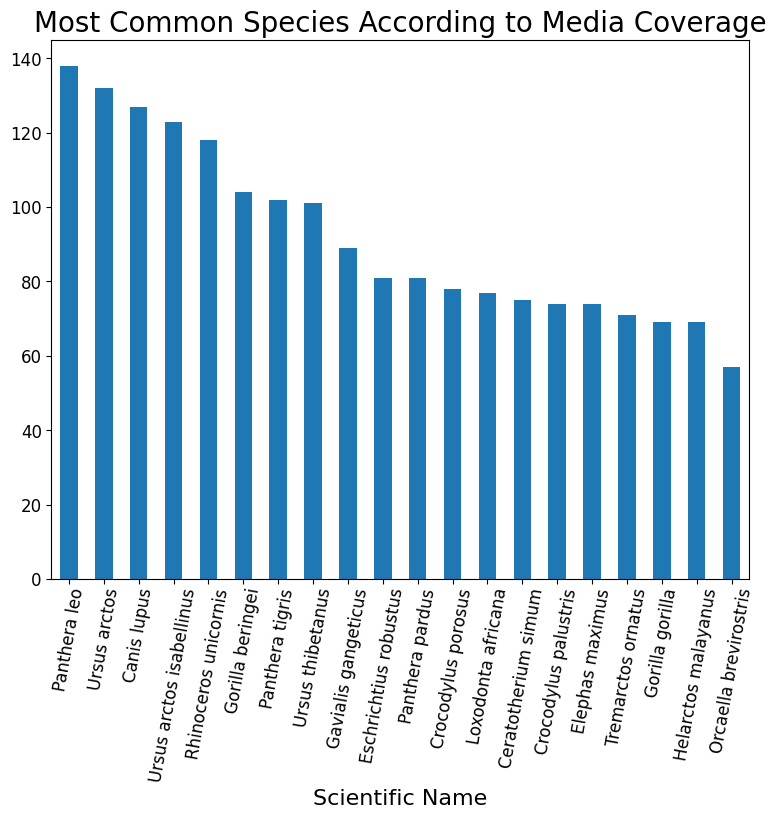

In [16]:
# What species are being reported on the most? 
# Create a simple bar graph displaying the amt of articles per species 

        
ax = article_totals_rz.nlargest(20).plot.bar(figsize = (9,7), fontsize = 12)
ax.set_xlabel('Scientific Name', fontsize=16)
ax.set_title('20 Most Common Species by Media Coverage', fontsize = 20)
ax.tick_params(axis='x', rotation=80, left = True, pad = 2)
#plt.savefig('top_20_species.png', bbox_inches = 'tight')

In [40]:
# Create a new dataframe with only the top 10 (or 20) most and least reported on species *
top_twen = df.loc[df['scientific_name'].isin(article_totals_rz.nlargest(20).keys())]

In [41]:
top_twen['scientific_name'].unique()

array(['Lophura swinhoii', 'Acrantophis dumerili', 'Amazona arausiaca',
       'Picathartes gymnocephalus', 'Amazona barbadensis',
       'Amazona finschi', 'Capricornis thar', 'Amazona pretrei',
       'Anas nesiotis', 'Chasmistes cujus', 'Gopherus flavomarginatus',
       'Ara rubrogenys', 'Tyto soumagnei', 'Pygathrix nigripes',
       'Cyanoramphus novaezelandiae', 'Aloe polyphylla',
       'Astrophytum asterias', 'Rhinopithecus avunculus',
       'Leopardus geoffroyi', 'Lontra longicaudis'], dtype=object)

In [18]:
# Define a function named 'get_ents' that takes a single object as input.
# We refer to this input using the variable name 'nlp_text'.
def get_ents(nlp_text, label):
    
    # First we make sure that the input is of correct type
    # by using the assert command to check the input type
    assert type(nlp_text) == spacy.tokens.doc.Doc
    
    # Let's set up a placeholder list for our ne's
    ents = []
    
    # We begin then begin looping over the Doc object
    for ent in nlp_text.ents:
        if (ent.label_ == label):
    
            # Append the ent text and label to the list of ents as a tuple
            ents.append(ent.text)
            
    # When the loop is complete, return the list of ents
    return ents

In [21]:
import spacy 
nlp = spacy.load('en_core_web_sm')

# Create a new column named 'processed_txt'
rizz_media['processed_txt'] = None

# Apply the language model under 'nlp' to the contents of the DataFrame column 'text'
rizz_media['processed_txt'] = rizz_media['text'].apply(nlp)

rizz_media.reset_index(drop=True, inplace=True)   

In [71]:
df = bottom_media.copy()
df['Key_Problems'] = None

df['Key_Problems'] = np.where(df.text.str.contains("illegal hunting | hunting | hunt them for | easy to hunt | relentless hunting"), "HUNTING",
                   np.where(df.text.str.contains("over-harvesting | overexploited | illegally poached | overexploitation | over-exploitation | \
                                                 poaching and trafficking | poachers | poaching | illegal poaching | illegal trafficking"), "POACHING",
                   np.where(df.text.str.contains("pet trade | international pet trade | underground trade | smuggling industry | over-harvested"), "PET TRADE",
                   np.where(df.text.str.contains("destruction of their habitat | habitat loss | damming | destruction of habitat | severe habitat encroachments | \
                   widespread habitat loss | over-hunting | habitat destruction | habitat fragmentation"), "HABITAT",         
                   np.where(df.text.str.contains("uncontrolled urbanisation | unsustainable industrialisation | Untreated wastewater | \
                   exploding human populations"), "URBANISATION",
                   np.where(df.text.str.contains("lax enforcement | ban enforcement | ban"), "POLICY",
                   np.where(df.text.str.contains("human consumption | considered a delicacy | exploitation for food | luxury food item | delicacy | \
                   source of traditional medicines | consumption demands | bushmeat | traditional medicine | being eaten"), "CONSUMPTION",        
                   np.where(df.text.str.contains("not genetically screened | diseases | genetic variation | Hybridization | spreading disease | disease"), "DISEASES",
                   np.where(df.text.str.contains("unsuitable for future reintroduction to the wild | breeding farms | raised on farms | impossible to keep alive in captivity | \
                   diseases originating on farms | captive-bred | capture myopathy"), "CAPTIVITY", "NA")))))))))       
         

#df.to_csv("bottom_20_articles_test.csv")

In [22]:
# Apply the 'get_ents' function to the column 'processed_txt'
#Create individual lists in order to store the values of different ents labels separately 
gpe_list = []
org_list = []
loc_list = []
event_list = []
norp_list = []

for i in rizz_media['processed_txt']:
    x = get_ents(i, "GPE")
    gpe_list.append(x)
    
    y = get_ents(i, "ORG")
    org_list.append(y)
    z = get_ents(i, "LOC")
    loc_list.append(z)
    v = get_ents(i, "EVENT")
    event_list.append(v)
    w = get_ents(i, "NORP")
    norp_list.append(w)
   
    #bottom_media['ents_GPE'] = bottom_media['ents_GPE'].append((get_ents(i, "GPE")))
    #bottom_media['ents_GPE'] = get_ents(i, "GPE")
    #bottom_media['ents_ORG'] = get_ents(i, "ORG")
    #bottom_media['ents_LOC'] = get_ents(i, "LOC")
    #bottom_media['ents_EVENT'] = get_ents(i, "EVENT")
    #bottom_media['ents_NORP'] = get_ents(i, "NORP")

    
# Call the variable to examine the output
#bottom_media

In [23]:
def list_to_graph(name):

    # Set up the placeholder list
    final_list = []

    # Loop over each list in the list of lists
    for nlist in name:
    
        # Extend the final list with the current list
        final_list.extend(nlist)
    
    # Convert the list into a pandas Series, count unique nouns
    # using the value_counts() method, get the 10 most frequent
    # items [:10] and plot the result into a bar chart using the
    # plot() method and its attribute 'kind'.
    return pd.Series(final_list).value_counts()[:10].plot(kind='bar')

<AxesSubplot: >

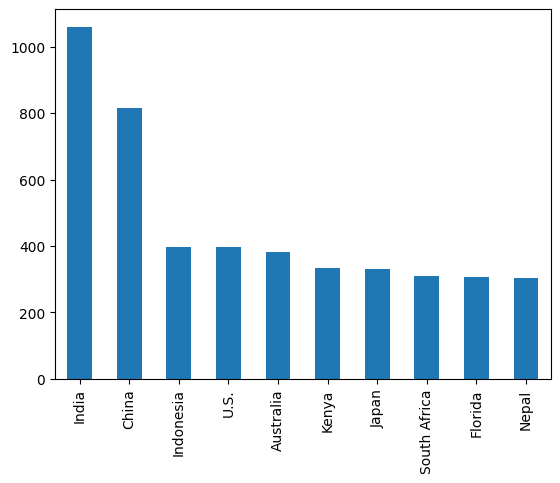

In [24]:
list_to_graph(gpe_list)

<AxesSubplot: >

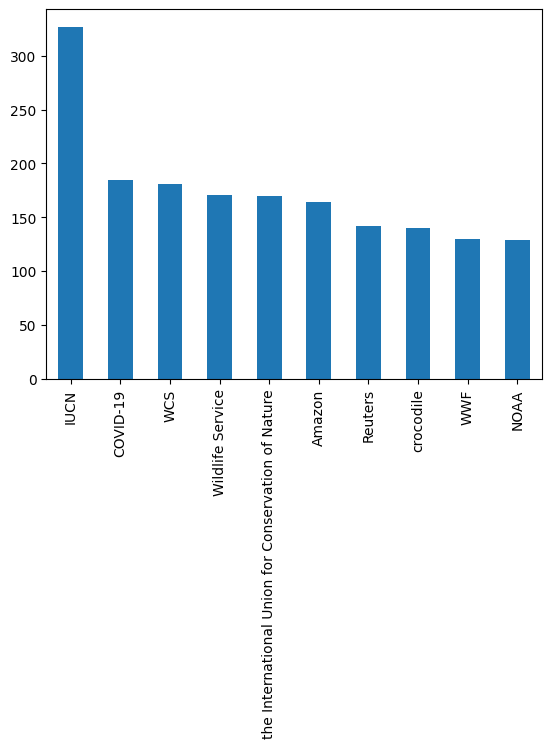

In [25]:
list_to_graph(org_list)

<AxesSubplot: >

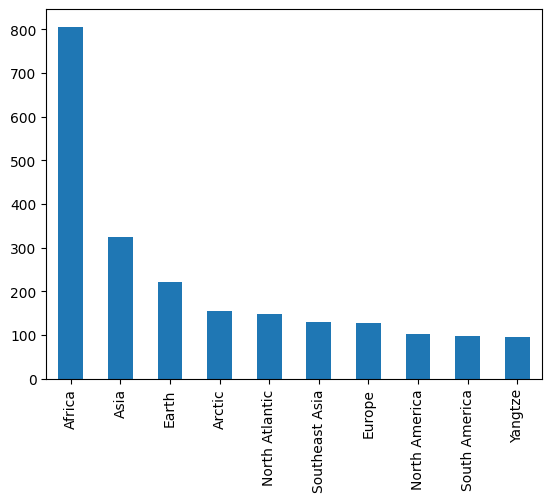

In [26]:
list_to_graph(loc_list)

<AxesSubplot: >

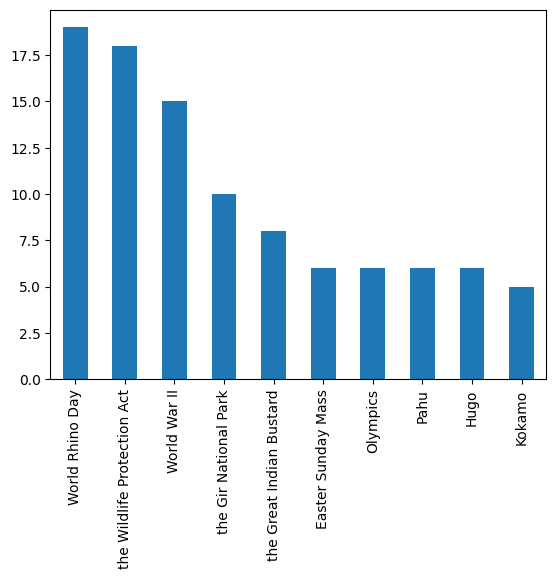

In [27]:
list_to_graph(event_list)

<AxesSubplot: >

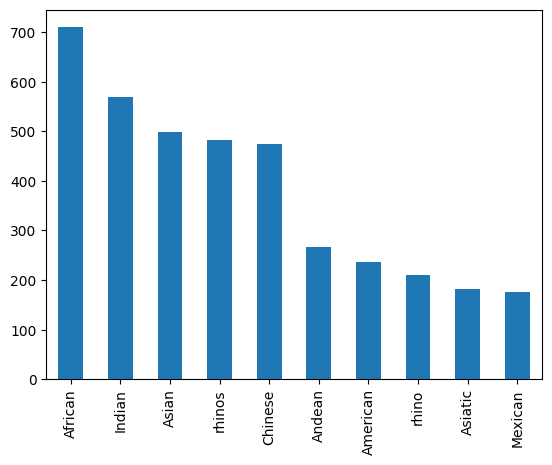

In [28]:
list_to_graph(norp_list)

In [65]:
# create a dataframe of the articles found under each species instance 
# How to bring over the species names that have been "identified" for each article? **

top_media = pd.DataFrame()

for i in top_twen.articles:
    for x in i.values():
        nd = pd.DataFrame.from_dict(x)
        top_media = pd.concat([top_media, nd])
        
        
# keep only unique article instances
top_media = top_media.drop_duplicates(subset=['text'])

# Transform date column into DateTime
top_media["date"] = pd.to_datetime(top_media["date"])
# Sort by oldest to newest
top_media = top_media.sort_values(by="date")
## lets run a quick keyword search
# 71 articles identified out of 1887. That is 3% of the dataset for Top 20 species
# Manual classification to asses what species are mentioned, geographic locations, reporting agency, information provided, accuracy and relevancy of information in conservation research of the species 
#illegaltrade_top20_articles = top20[top20['text'].str.contains('seiz|confiscat')]
#top_media[top_media['text'].str.contains('seiz|confiscat|trade|poach')]
# Save articles dataframe
#illegaltrade_top20_articles.to_csv("illegaltrade_top20_articles.csv")
top_media

text  \
0   The Cruel Wildlife Market\n\nHundreds of cages...   
0   Naismith went to the toilet after her plane ha...   
0   The long-nosed bandicoot has made a return to ...   
0   A TRAWDEN man couldn’t believe his eyes when h...   
0   In 2007, an inspired group of sea turtle resea...   
..                                                ...   
0   Creatures in forests, oceans, zoos, and even i...   
0   Sign up to FREE email alerts from Nottinghamsh...   
0   India batsman K.L. Rahul has applauded the unw...   
0   Lonzo Ball is never one to shy away from an op...   
0   india\n\nUpdated: Dec 30, 2019 23:09 IST\n\nTh...   

                                                title  \
0   Indonesia Field Report IV: The Last Twitch? Wi...   
0         Collectors feed bizarre smuggling escapades   
0        Long-nosed bandicoot returns to inner Sydney   
0                      'Albino' bird lands in Trawden   
0                 The Great Turtle Race begins again!   
..                                                ...   
0      21 mind-boggling world records held by animals   
0   Grave of Notts man 'mauled' by tiger in 1915 u...   
0   KL Rahul hails relentless efforts of frontline...   
0   Lonzo Ball jokingly compares JJ Redick, Jrue H...   
0   Sunderbans lost 2% mangrove cover in two years...   

                                                 link  \
0   https://news.google.com/articles/CBMilwFodHRwc...   
0   https://news.google.com/articles/CBMiY2h0dHBzO...   
0   https://news.google.com/articles/CBMiWmh0dHBzO...   
0   https://news.google.com/articles/CBMiUmh0dHBzO...   
0   https://news.google.com/articles/CBMiR2h0dHBzO...   
..                                                ...   
0   https://news.google.com/articles/CAIiEByfE3XWr...   
0   https://news.google.com/articles/CBMiU2h0dHBzO...   
0   https://news.google.com/articles/CAIiECaj5dLA_...   
0   https://news.google.com/articles/CBMihAFodHRwc...   
0   https://news.google.com/articles/CAIiEG63tUf-a...   

                                                image       date  \
0   https://www.brookings.edu/wp-content/uploads/2... 2001-11-30   
0                https://www.theage.com.au/theage.png 2007-03-11   
0   https://www.abc.net.au/cm/rimage/651260-16x9-l... 2007-08-26   
0   https://www.lancashiretelegraph.co.uk/resource... 2008-07-06   
0   https://deepseanews.com/wp-content/uploads/200... 2009-04-16   
..                                                ...        ...   
0   https://i.insider.com/5ea6f630d553f8036c5b76b2... 2020-05-30   
0   https://i2-prod.nottinghampost.com/incoming/ar... 2020-05-30   
0   https://www.thestatesman.com/wp-content/upload... 2020-05-30   
0   https://usatlonzowire.files.wordpress.com/2020... 2020-05-31   
0   https://www.hindustantimes.com/rf/image_size_9... 2020-12-30   

                                                  ner  
0   {'sent': 'Hundreds of cages with birds, lizard...  
0   {'sent': 'She said she went to Singapore for a...  
0   {'sent': 'The long-nosed bandicoot has made a ...  
0   {'sent': 'Stunned Alan Southworth, 74, of Boul...  
0   {'sent': 'In 2007, an inspired group of sea tu...  
..                                                ...  
0   {'sent': 'The longest crocodile in captivity m...  
0   {'sent': 'Sign up to FREE email alerts from No...  
0   {'sent': 'India batsman K.L. Rahul has applaud...  
0   {'sent': 'Lonzo Ball is never one to shy away ...  
0     {'sent': 'india

', 'ents': {'GPE': ['india']}}  

[1887 rows x 6 columns]

In [66]:
# Create a new column named 'processed_txt'
top_media['processed_txt'] = None

# Apply the language model under 'nlp' to the contents of the DataFrame column 'text'
top_media['processed_txt'] = top_media['text'].apply(nlp)

# Apply the 'get_ents' function to the column 'processed_txt'
#Create individual lists in order to store the values of different ents labels separately 
gpe_list1 = []
org_list1 = []
loc_list1 = []
event_list1 = []
norp_list1 = []

for i in top_media['processed_txt']:
    x = get_ents(i, "GPE")
    gpe_list1.append(x)
    
    y = get_ents(i, "ORG")
    org_list1.append(y)
    z = get_ents(i, "LOC")
    loc_list1.append(z)
    v = get_ents(i, "EVENT")
    event_list1.append(v)
    w = get_ents(i, "NORP")
    norp_list1.append(w)

<AxesSubplot: >

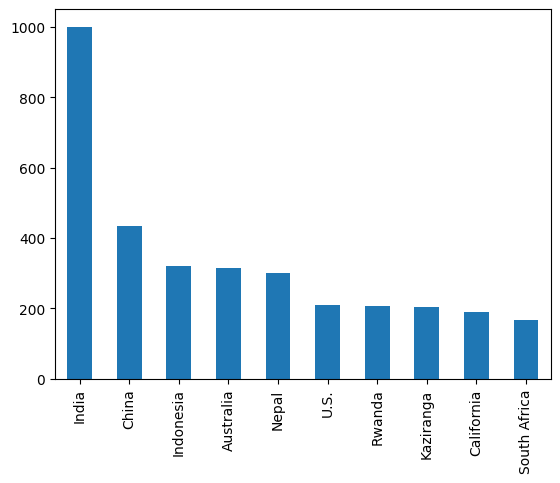

In [67]:
list_to_graph(gpe_list1)

<AxesSubplot: >

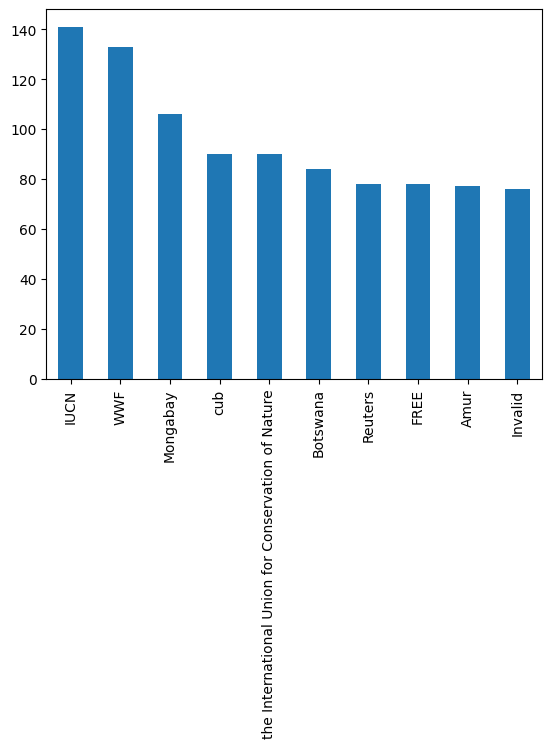

In [68]:
list_to_graph(org_list1)

<AxesSubplot: >

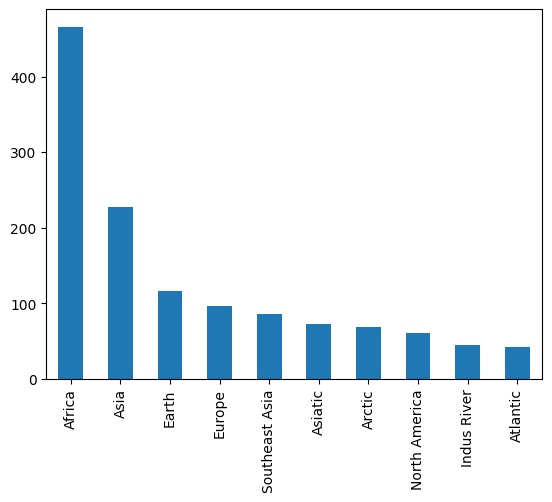

In [69]:
list_to_graph(loc_list1)

<AxesSubplot: >

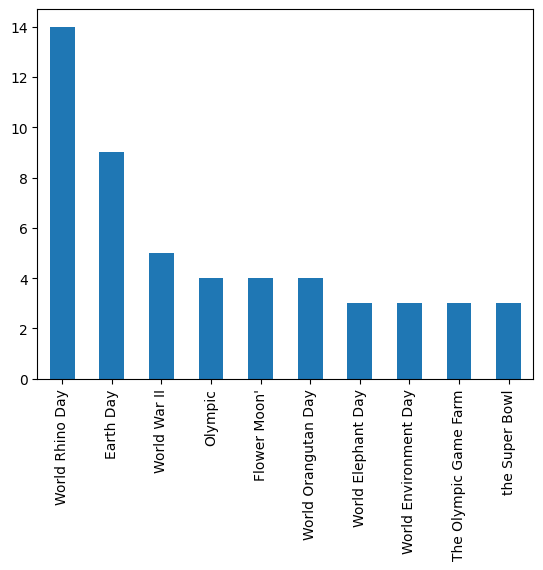

In [70]:
list_to_graph(event_list1)

<AxesSubplot: >

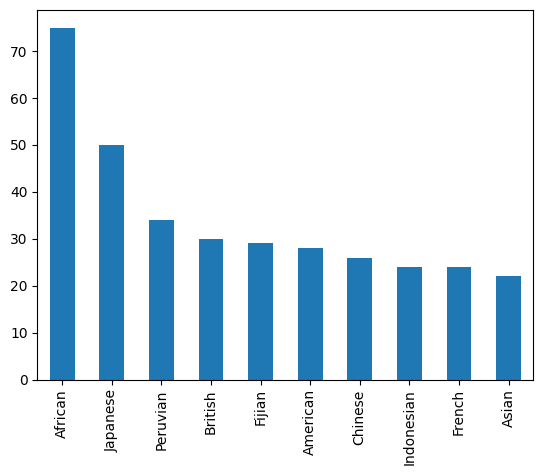

In [71]:
list_to_graph(norp_list)

# BACK to WHOLE DATASET SAMPLE

In [10]:
# Whole dataset articles
read = pd.DataFrame()

for i in df.articles:
    for x in i.values():
        nd = pd.DataFrame.from_dict(x)
        read = pd.concat([read, nd])

# keep only unique article instances
read = read.drop_duplicates(subset=['text'])

# Transform date column into DateTime
read["date"] = pd.to_datetime(read["date"])
# Sort by oldest to newest
read = read.sort_values(by="date")

read.head()

KeyboardInterrupt: 

<AxesSubplot:xlabel='date'>

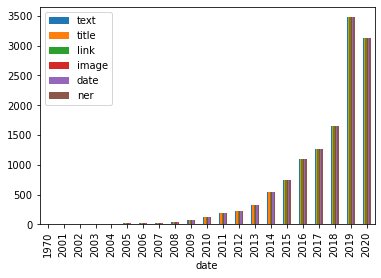

In [20]:
# Create a quick visualization of the date distribution 
read.groupby(read["date"].dt.year).count().plot(kind="bar")

In [15]:
# Read in the CITES data to join with the top 10 (or 20) most reported on species 
cites1 = pd.read_csv("cites1.csv", delimiter = ';')

# Keep only most relevant columns
cites1 = cites1[['Kingdom', 'Class', 'Order', 'Family', 'Genus', 'Species', 'Scientific Name', 'Listing', 'NativeDistributionFullNames', 'Extinct_Distribution']]

#cites1 = cites1.rename(columns = {'FullName' : 'scientific_name'})

cites1

Kingdom     Class         Order          Family          Genus  \
0     Animalia  Mammalia  Artiodactyla  Antilocapridae    Antilocapra   
1     Animalia  Mammalia  Artiodactyla         Bovidae          Addax   
2     Animalia  Mammalia  Artiodactyla         Bovidae            Bos   
3     Animalia  Mammalia  Artiodactyla         Bovidae            Bos   
4     Animalia  Mammalia  Artiodactyla         Bovidae            Bos   
...        ...       ...           ...             ...            ...   
1132   Plantae       NaN     Cycadales       Zamiaceae  Encephalartos   
1133   Plantae       NaN     Cycadales       Zamiaceae  Encephalartos   
1134   Plantae       NaN     Cycadales       Zamiaceae  Encephalartos   
1135   Plantae       NaN     Cycadales       Zamiaceae     Microcycas   
1136   Plantae       NaN     Cycadales       Zamiaceae          Zamia   

            Species            Scientific Name Listing  \
0         americana      Antilocapra americana       I   
1     nasomaculatus        Addax nasomaculatus       I   
2            gaurus                 Bos gaurus       I   
3             mutus                  Bos mutus       I   
4           sauveli                Bos sauveli       I   
...             ...                        ...     ...   
1132       villosus     Encephalartos villosus       I   
1133    whitelockii  Encephalartos whitelockii       I   
1134         woodii       Encephalartos woodii       I   
1135       calocoma        Microcycas calocoma       I   
1136      restrepoi            Zamia restrepoi       I   

                            NativeDistributionFullNames  \
0                Canada,Mexico,United States of America   
1                      Chad,Mali,Mauritania,Niger,Sudan   
2     Bangladesh,Bhutan,Cambodia,China,India,Lao Peo...   
3                                     China,India,Nepal   
4                                                   NaN   
...                                                 ...   
1132                   Eswatini,Mozambique,South Africa   
1133                                             Uganda   
1134                                                NaN   
1135                                               Cuba   
1136                                           Colombia   

                                   Extinct_Distribution  
0                                                   NaN  
1     Algeria,Egypt,Libya,Morocco,Tunisia,Western Sa...  
2                                             Sri Lanka  
3                Kazakhstan,Mongolia,Russian Federation  
4                                                   NaN  
...                                                 ...  
1132                                                NaN  
1133                                                NaN  
1134                                       South Africa  
1135                                                NaN  
1136                                                NaN  

[1137 rows x 10 columns]

In [17]:
# Simplify the IUCN categories

df["iucn_status"].replace({"Least Concern": "LC", "Lower Risk/least concern": "LC", 
                                "Vulnerable" : "VU", "Near Threatened" : "NT", "Critically Endangered" : "CR",
                          "Extinct in the Wild" : "EW", "Endangered" : "EN", "Data Deficient" : "DD", 
                          "Extinct" : "EX"}, inplace=True)

df['iucn_status'].unique()

## DROP NA
df_mod = df[ (df['iucn_status'] != 'NA') & (df['iucn_status'] != ' Brede & Rödel')]
df_mod
#df.drop(df.loc[df['iucn_status'].isin(['NA'])])
#df.loc[df['scientific_name'].isin(['Perameles bougainville'])]

/tmp/ipykernel_93/1468945897.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["iucn_status"].replace({"Least Concern": "LC", "Lower Risk/least concern": "LC",


array(['CR', 'LC', 'NT', 'NA', 'EW', 'VU', 'EN', 'DD', 'EX',
       'Lower Risk/conservation dependent', ' Brede & Rödel'],
      dtype=object)

In [19]:
# Assigning each category a more relevant color
cmap = {'CR': 'red', 'EN': 'orange', 'VU': 'yellow', 'NT': 'green', 'LC': 'blue'}

In [24]:
colors = ['#2059BA','#FAE666','#A90A0A','#F9820B', '#128A16']

Text(0.5, 1.0, 'IUCN Status Share of Dataset')

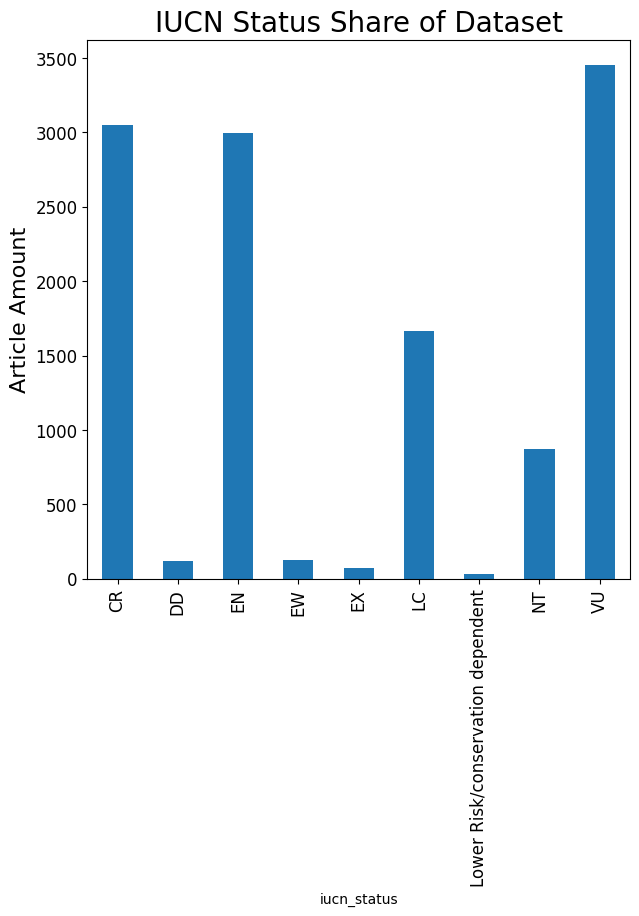

In [40]:
# Group dataframe by the scientific name that remains consistent for all rows 
grouped_i = df_mod.groupby('iucn_status')

# Calculate the totals of the group species
article_totals_i = grouped_i.article_amt.sum().round()


# What species are being reported on the most? 
# Create a simple bar graph displaying the amt of articles per species 
ax = article_totals_i.plot.bar(cmap, figsize = (7,7), 
                                                fontsize = 12)
ax.set_ylabel('Article Amount', fontsize=16)
ax.set_title('IUCN Status Share of Dataset', fontsize = 20)
#plt.savefig('IUCN-share.png', bbox_inches = 'tight')

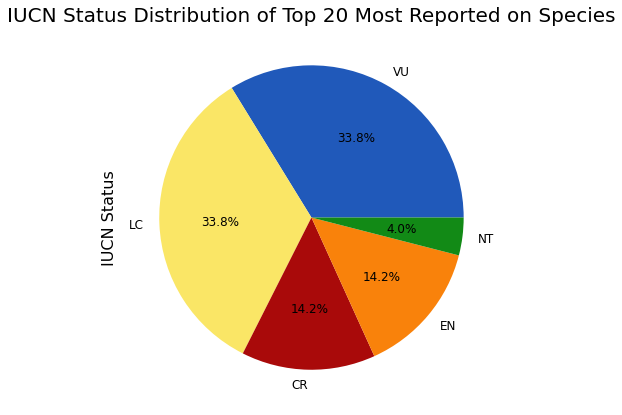

In [27]:
# Defining parameters for pie chart of IUCN Status
ax = top_twen['iucn_status'].value_counts().plot(kind = 'pie', autopct="%1.1f%%", figsize = (7,7), 
                                                fontsize = 12, colors = colors)

ax.set_ylabel('IUCN Status', fontsize=16)
ax.set_title('IUCN Status Distribution of Top 20 Most Reported on Species', fontsize = 20)
plt.savefig('IUCN-status.png', bbox_inches = 'tight')

In [32]:
# A quick look at the species' distribution
g = top_twen['article_amt'].groupby(top_twen['scientific_name'])



In [90]:
# Create a simplified version of the dataframe
smplfd = top_twen[['scientific_name', 'distribution', 'iucn_status']]
smplfd.drop_duplicates(inplace = True)
smplfd.reset_index(drop = True, inplace = True)
# Conduct merges of the dataframes
smplfd.merge(cites1, on = 'scientific_name', how = 'inner')
smplfd

In [35]:
# Do the same for the entire dataframe
df = df.merge(cites1, on = 'scientific_name', how = 'inner')

In [42]:
# Group dataframe by the Kingdom that remains consistent for all rows 
grouped_k = df.groupby('Kingdom')

# Calculate the totals of the group Kingdom
article_totals_k = grouped_k.article_amt.sum().round()

In [43]:
article_totals_k

Kingdom
Animalia    13390.0
Plantae       175.0
Name: article_amt, dtype: float64

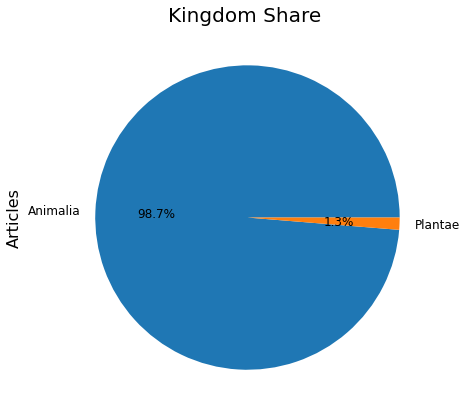

In [59]:
# What Kingdom is being reported on the most? 
# Create a simple pie chart displaying the amt of articles per Kingdom
ax = article_totals_k.plot.pie(y = 'Kingdom', autopct="%1.1f%%", figsize = (7,7), fontsize = 12)
ax.set_ylabel('Articles', labelpad = 35, fontsize=16)
ax.set_title('Kingdom Share ', fontsize = 20)
plt.savefig('Kingdom-Share.png', bbox_inches = 'tight')


In [73]:
df['Class'].value_counts()

Mammalia          1220
Aves               498
Reptilia           338
Actinopteri         46
Amphibia            30
Elasmobranchii      24
Bivalvia            24
Coelacanthi          9
Insecta              8
Name: Class, dtype: int64

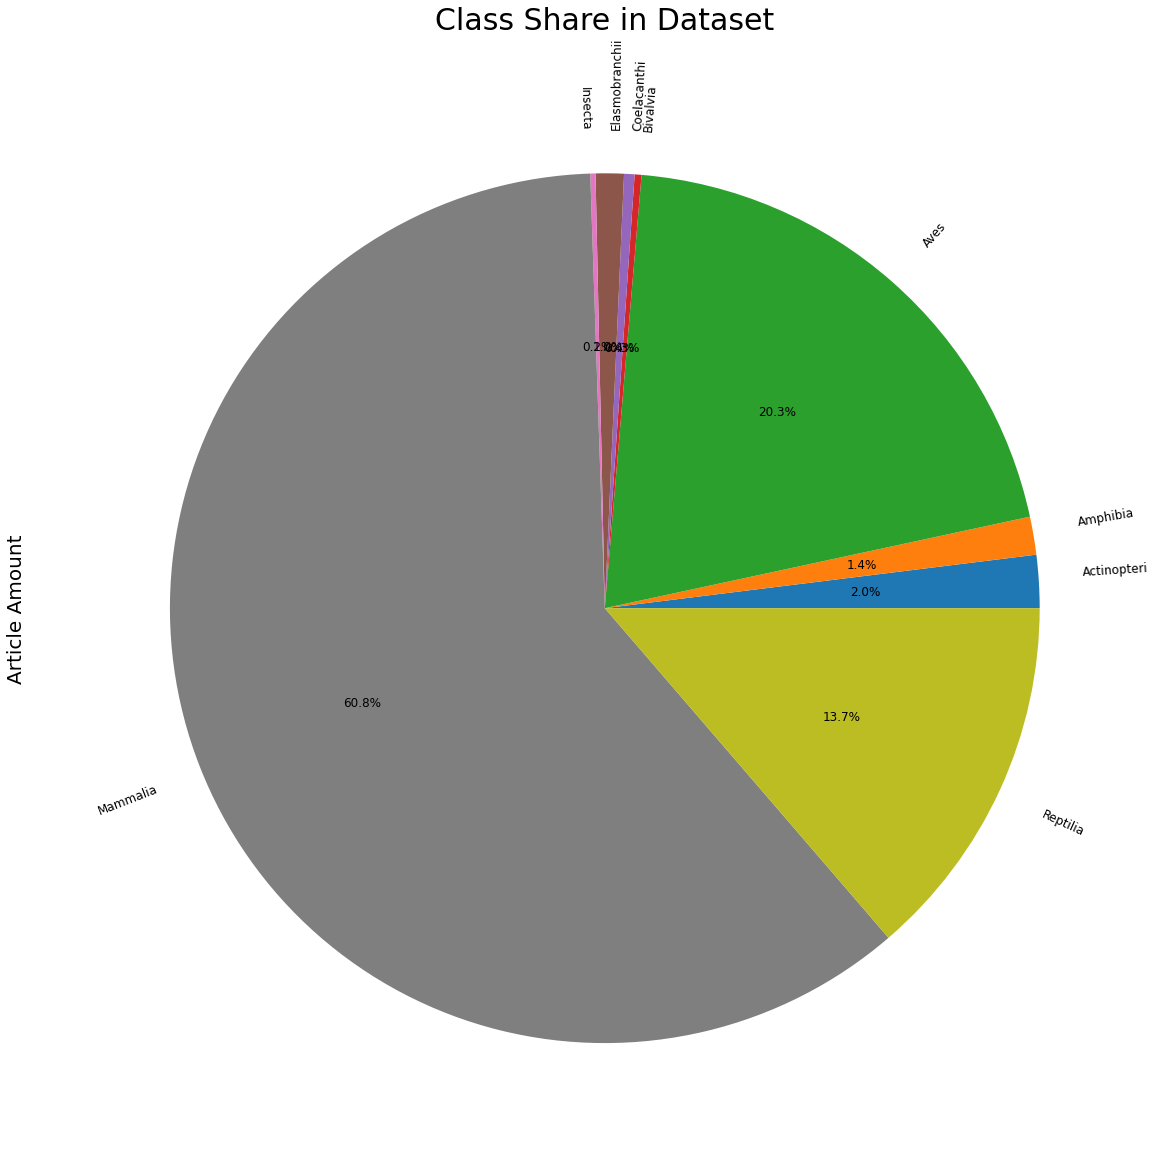

In [70]:
# Group dataframe by the Class that remains consistent for all rows 
grouped_c = df.groupby('Class')

# Calculate the totals of the Classes
article_totals_c = grouped_c.article_amt.sum().round()


# What Class is being reported on the most? 
# Create a simple pie graph displaying the amt of articles per species 
ax = article_totals_c.plot.bar(figsize = (20,20), autopct="%1.1f%%", fontsize = 12, rotatelabels=True)

ax.set_ylabel('Article Amount', labelpad = 35, fontsize=20)
ax.set_title('Class Share in Dataset', pad = 35, fontsize = 30)
plt.savefig('class-share.png', bbox_inches = 'tight')

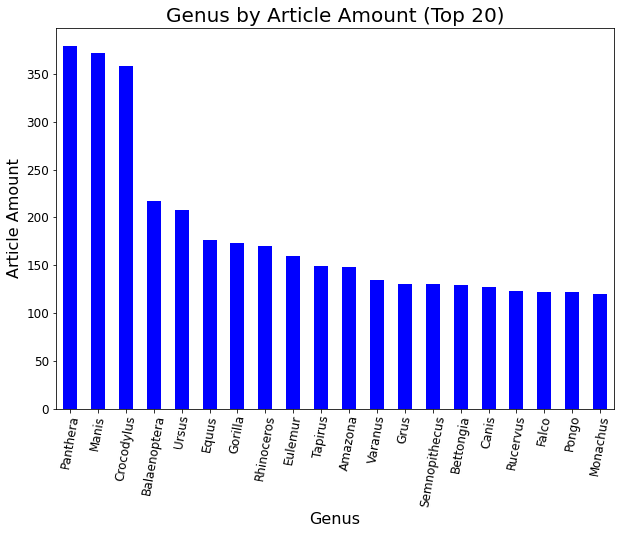

In [78]:
# Group dataframe by the scientific name that remains consistent for all rows 
grouped_G = df.groupby('Genus')

# Calculate the totals of the group species
article_totals_G = grouped_G.article_amt.sum().round()


# What species are being reported on the most? 
# Create a simple bar graph displaying the amt of articles per species 
ax = article_totals_G.nlargest(20).plot.bar(color = 'blue', figsize = (10,7), fontsize = 12)
ax.set_xlabel('Genus', fontsize=16)
ax.set_ylabel('Article Amount', fontsize = 16)
ax.set_title('Genus by Article Amount (Top 20)', fontsize = 20)
ax.tick_params(axis='x', rotation=80, left = True, pad = 2)
plt.savefig('top_20_genus.png', bbox_inches = 'tight')

13/04/22

Next visualization step:
- Don't just visualize the dataset, look at the corresponding articles published for that class! for that genus! SO need to do groupby functions 